# Importing Libraries

In [1]:
#from google.colab import files
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from keras.applications.mobilenet import MobileNet
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

Loading Data from Kaggle

In [2]:
# if not os.path.exists(os.path.expanduser('~')+'/.kaggle'):
#     ! mkdir ~/.kaggle
# os.chdir(os.path.expanduser('~')+'/.kaggle')
# if not os.path.exists(os.path.expanduser('~')+'/.kaggle/kaggle.json'):
#     kaggle_api_file = files.upload()
#     ! kaggle datasets download -d grassknoted/asl-alphabet
#     ! unzip -q asl-alphabet.zip
#     ! rm -rf asl_alphabet_train/asl_alphabet_train/del

In [3]:
! rm -rf ../input/asl-alphabetasl_alphabet_train/asl_alphabet_train/del

# Data Preprocessing and Augmentation

In [4]:
train_data = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

In [5]:
image_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.2, 1),
    shear_range=45,
    zoom_range=(0.5, 1.5),
    fill_mode='reflect',
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.2
    )

In [6]:
train_gen = image_gen.flow_from_directory(
    train_data,
    target_size=(224,224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=32,
    seed=0,
    subset='training'
    )


Found 69600 images belonging to 29 classes.


In [7]:
val_gen = image_gen.flow_from_directory(
    train_data,
    target_size=(224,224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=32,
    seed=0,
    subset='validation'
    )


Found 17400 images belonging to 29 classes.


In [8]:
train_gen.class_indices


{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

# Creating the Model

In [9]:
base_model = MobileNet(include_top=False,
                        weights='imagenet',
                        input_shape=(224,224,3),
                        pooling='avg')

end_model = models.Sequential()
end_model.add(layers.Flatten(input_shape=base_model.output_shape[1:]))
end_model.add(layers.Dense(128))
end_model.add(layers.ReLU())
end_model.add(layers.Dense(64))
end_model.add(layers.LeakyReLU())
end_model.add(layers.Dense(29, activation='softmax'))

model = models.Model(inputs=base_model.input, outputs=end_model(base_model.output))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

2022-03-08 13:00:20.936785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 13:00:21.061304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 13:00:21.062404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 13:00:21.064531: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
______________________________________________________________

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        mode='min',
                                        restore_best_weights=True)

# Training the model

In [12]:
history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=[early_stopping_callback]
    )

2022-03-08 13:00:25.656520: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-03-08 13:00:29.336665: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2175/2175 [==============================] - 1658s 759ms/step - loss: 1.0055 - accuracy: 0.6907 - val_loss: 1.1535 - val_accuracy: 0.6486
Epoch 2/25
2175/2175 [==============================] - 1296s 596ms/step - loss: 0.6158 - accuracy: 0.8032 - val_loss: 1.0256 - val_accuracy: 0.6911
Epoch 3/25
2175/2175 [==============================] - 1295s 596ms/step - loss: 0.5434 - accuracy: 0.8257 - val_loss: 0.9915 - val_accuracy: 0.7083
Epoch 4/25
2175/2175 [==============================] - 1277s 587ms/step - loss: 0.4957 - accuracy: 0.8409 - val_loss: 0.9832 - val_accuracy: 0.7036
Epoch 5/25
2175/2175 [==============================] - 1286s 591ms/step - loss: 0.4663 - accuracy: 0.8500 - val_loss: 0.8960 - val_accuracy: 0.7252
Epoch 6/25
2175/2175 [==============================] - 1277s 587ms/step - loss: 0.4433 - accuracy: 0.8569 - val_loss: 1.0092 - val_accuracy: 0.7083
Epoch 7/25
2175/2175 [==============================] - 1249s 574ms/step - loss: 0.4228 - accuracy: 0.8643 - val_loss

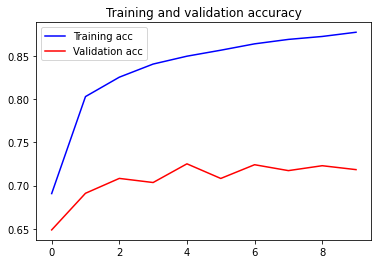

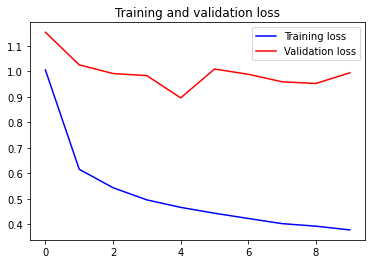

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Saving Model

In [16]:
model.save('./asl_mobilenet_data_augmentation.h5')